In [102]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  


In [103]:
users = pd.read_csv('cleaned_users.csv')
books = pd.read_csv('cleaned_books.csv')
ratings = pd.read_csv('Filtered_HighQuality_Ratings.csv')

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(ratings, books, on='ISBN', how='inner')

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(ratings, books, on='ISBN', how='inner')
# Second merge: Resulting DataFrame with Users on 'User-ID'
final_merged_df = pd.merge(ratings_books_merged, users, on='User-ID', how='inner')
# Save the merged DataFrame to a new CSV file
final_merged_df.to_csv('final_merge.csv', index=False)


In [104]:
#data = pd.read_csv('final_merge.csv')
df = pd.read_csv('final_merge.csv')
data = df.dropna()
data.reset_index(drop=True, inplace=True)

data

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Bin,Book-Author-Encode,Book-Publisher-Encode,...,Filtered-Title,User-City,User-State,User-Country,User-Age,User-Age-Bin,User-City_Encoded,User-State_Encoded,User-Country_Encoded,User-Age-Encoded
0,277427,002542730X,10,politically correct bedtime story modern tale ...,James Finn Garner,1994,John Wiley & Sons Inc,"[1980, 2000)",2660,622,...,politically correct bedtime modern tale life ...,others,others,usa,48,40~60,19,23,6,2
1,277427,0060006641,10,writing well th anniversary classic guide writ...,William Zinsser,2001,HarperResource,"[2000, 2020)",6400,525,...,writing well th anniversary classic guide writ...,others,others,usa,48,40~60,19,23,6,2
2,277427,0060542128,7,storm break,Heather Lowell,2003,HarperTorch,"[2000, 2020)",2330,528,...,storm break,others,others,usa,48,40~60,19,23,6,2
3,277427,0061009059,9,one money stephanie plum novel paperback,Janet Evanovich,1995,HarperTorch,"[1980, 2000)",2766,528,...,one money stephanie plum,others,others,usa,48,40~60,19,23,6,2
4,277427,0152050167,10,whale rider,Witi Ihimaera,2003,Harcourt Paperbacks,"[2000, 2020)",6405,495,...,whale rider,others,others,usa,48,40~60,19,23,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54554,276680,1573221562,10,affinity,Sarah Waters,2000,Riverhead Books,"[2000, 2020)",5578,1003,...,affinity,others,new york,usa,55,40~60,19,18,6,2
54555,276680,1573222038,10,fingersmith,Sarah Waters,2002,Riverhead Hardcover,"[2000, 2020)",5578,1004,...,fingersmith,others,new york,usa,55,40~60,19,18,6,2
54556,276680,1573229083,7,dream,Nuala O'Faolain,2002,Riverhead Books,"[2000, 2020)",4698,1003,...,dream,others,new york,usa,55,40~60,19,18,6,2
54557,276680,1888173408,7,fairy tale common reader edition,Alice Thomas Ellis,2001,Akadine Press,"[2000, 2020)",184,27,...,fairy tale common reader edition,others,new york,usa,55,40~60,19,18,6,2


In [105]:
# Select relevant features
features = data[['User-ID', 'Year-Of-Publication-Bin-Encode', 'Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating', 'User-Country_Encoded','User-City_Encoded','User-State_Encoded', 'User-Age-Encoded']]
features


,User-ID,Year-Of-Publication-Bin-Encode,Book-Author-Encode,Book-Publisher-Encode,Book-Rating,User-Country_Encoded,User-City_Encoded,User-State_Encoded,User-Age-Encoded
0,277427,4,2660,622,10,6,19,23,2
1,277427,5,6400,525,10,6,19,23,2
2,277427,5,2330,528,7,6,19,23,2
3,277427,4,2766,528,9,6,19,23,2
4,277427,5,6405,495,10,6,19,23,2
...,...,...,...,...,...,...,...,...,...
54554,276680,5,5578,1003,10,6,19,18,2
54555,276680,5,5578,1004,10,6,19,18,2
54556,276680,5,4698,1003,7,6,19,18,2
54557,276680,5,184,27,7,6,19,18,2


In [106]:
# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

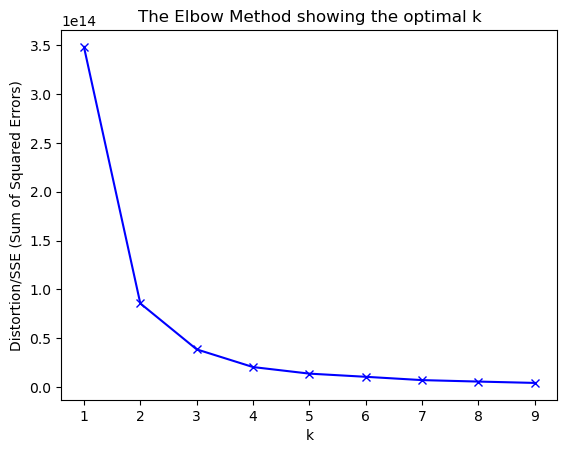

In [107]:
distortions = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    distortions.append(kmeans.inertia_) 
    
plt.plot(k_range, distortions, 'bx-')

plt.title('The Elbow Method showing the optimal k')
plt.xlabel('k')
plt.ylabel('Distortion/SSE (Sum of Squared Errors)')

plt.show()

In [108]:
# Define the range of k
k_values = range(1, 11)  # You can adjust this range based on your specific needs

# Initialize list to store SSE values
sse = []

# Calculate SSE for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center

# Print the SSE values
for k, sse_value in zip(k_values, sse):
    print(f"SSE for k={k}: {sse_value}")

SSE for k=1: 491031.0000000008
SSE for k=2: 446594.80059693125
SSE for k=3: 406538.6786883661
SSE for k=4: 368485.3213131953
SSE for k=5: 351206.0522838642
SSE for k=6: 335411.46290021355
SSE for k=7: 308642.10956683184
SSE for k=8: 305099.7577018847
SSE for k=9: 290711.9461329652
SSE for k=10: 274709.69733632024


In [109]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=3)  # Reduce to 3 dimensions for plotting
principal_components = pca.fit_transform(features_scaled)

In [110]:
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(principal_components)

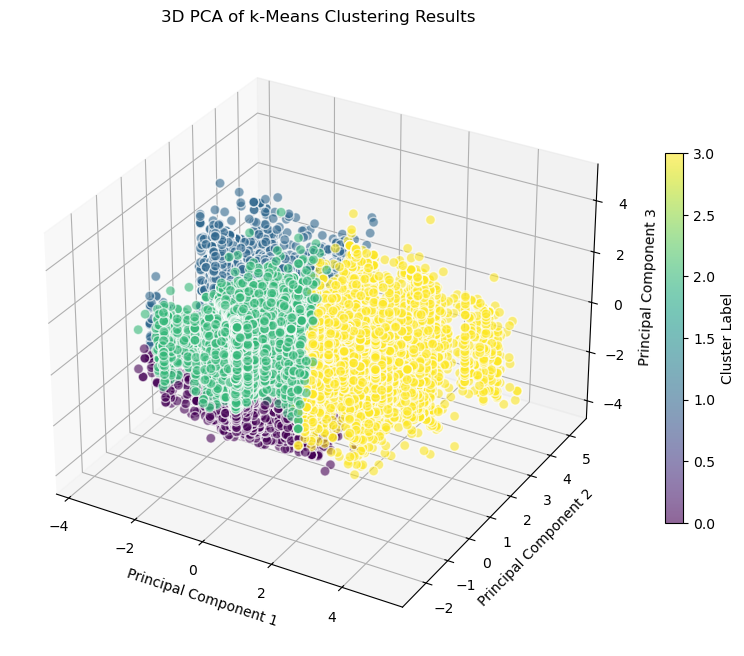

In [111]:
# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], 
                     principal_components[:, 1], 
                     principal_components[:, 2], 
                     c=clusters, cmap='viridis', marker='o', alpha=0.6, edgecolor='w', s=50)

# Axis labeling
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of k-Means Clustering Results')

# Color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Cluster Label')

# Show plot
plt.show()

In [112]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
principal_components = pca.fit_transform(features_scaled)

In [113]:
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(principal_components)

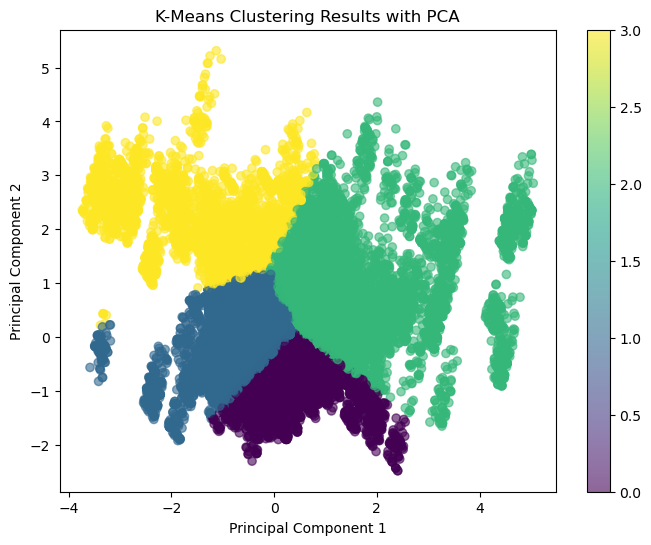

In [114]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering Results with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

In [115]:
# Assign clusters back to the original data
data['Cluster'] = clusters

/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_3270/1985339526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = clusters


In [116]:
# Aggregating data by clusters
cluster_profiles = data.groupby('Cluster').agg({
    'User-Age-Encoded': 'mean',  # Assuming age is continuous and encoded
    'User-Country_Encoded': lambda x: x.mode()[0],  # Mode of location
    'User-State_Encoded': lambda x: x.mode()[0],  # Mode of location
    'User-City_Encoded': lambda x: x.mode()[0],  # Mode of location
    'Book-Author-Encode': lambda x: x.mode()[0],  # Mode of favorite author
    'Book-Publisher-Encode': lambda x: x.mode()[0],  # Mode of favorite publisher
    'Year-Of-Publication-Bin-Encode': lambda x: x.mode()[0],
    'Book-Rating': 'mean'  # Average rating
}).rename(columns={
    'User-Age-Encoded': 'age',
    'User-Country_Encoded': 'country_mode',
    'User-City_Encoded': 'city_mode',
    'User-State_Encoded': 'state_mode',
    'Book-Author-Encode': 'favorite_author',
    'Book-Publisher-Encode': 'favorite_publisher',
    'Book-Rating': 'average_rating',
    'Year-Of-Publication-Bin-Encode': 'favorite_publication_year'
})

# Print or output the cluster profiles
print(cluster_profiles)

              age  country_mode  state_mode  city_mode  favorite_author  \
Cluster                                                                   
0        1.989550             6          23         19             5762   
1        1.776051             6          23         19             5762   
2        3.076540             6           5         19             5762   
3        2.021552             1          22         19             5762   

         favorite_publisher  favorite_publication_year  average_rating  
Cluster                                                                 
0                       913                          4        8.527006  
1                       111                          4        7.829568  
2                       111                          4        7.226457  
3                       111                          4        7.422619  
